In [1]:
import os
import random
import urllib.request
from urllib.error import HTTPError

import numpy as np
import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from dataset import DirImagesDataset


In [2]:
class Encoder(nn.Module):
    def __init__(self, input_channels: int, base_channels: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        
        ch = base_channels
        
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, ch, kernel_size=3, padding=1, stride=2),  # 64x64 => 32x32
            act_fn(),
            nn.Conv2d(ch, ch, kernel_size=3, padding=1),
            act_fn(),
            
            nn.Conv2d(ch, ch*2, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(ch*2, ch*2, kernel_size=3, padding=1),
            act_fn(),
            
            nn.Conv2d(ch*2, ch*4, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(ch*4, ch*4, kernel_size=3, padding=1),
            act_fn(),
            
            nn.Conv2d(ch*4, ch*8, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Conv2d(ch*8, ch*8, kernel_size=3, padding=1),
            act_fn(),
            
            nn.Flatten(),
            nn.Linear(16 * 8 * ch, 2*latent_dim),
            act_fn(),
            nn.Linear(2*latent_dim, latent_dim),
        )

    def forward(self, x):
        return self.net(x)
    

encoder = Encoder(3, base_channels=8, latent_dim=64)
out = encoder.forward(torch.zeros((32, 3, 64, 64)))
print(out.shape)

torch.Size([32, 64])


In [3]:
class Decoder(nn.Module):
    def __init__(self, input_channels: int, base_channels: int, latent_dim: int, act_fn: object = nn.GELU):
        super().__init__()
        ch = base_channels
        
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*latent_dim),
            act_fn(),
            nn.Linear(2*latent_dim, 16 * 8 * ch),
            act_fn(),
        )
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(ch*8, ch*8, kernel_size=3, output_padding=1, padding=1, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(ch*8, ch*4, kernel_size=3, padding=1),
            act_fn(),
            
            nn.ConvTranspose2d(ch*4, ch*4, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(ch*4, ch*2, kernel_size=3, padding=1),
            act_fn(),
            
            nn.ConvTranspose2d(ch*2, ch*2, kernel_size=3, output_padding=1, padding=1, stride=2),  # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(ch*2, ch, kernel_size=3, padding=1),
            act_fn(),
            
            nn.ConvTranspose2d(ch, ch, kernel_size=3, output_padding=1, padding=1, stride=2),  # 32x32 => 64x64
            act_fn(),
            nn.Conv2d(ch, input_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x
    
    
decoder = Decoder(3, base_channels=8, latent_dim=64)
out = decoder.forward(torch.zeros((32, 64)))
print(out.shape)

torch.Size([32, 3, 64, 64])


In [16]:
class Autoencoder(L.LightningModule):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        num_input_channels: int = 3,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(num_input_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_input_channels, base_channel_size, latent_dim)
        self.example_input_array = torch.zeros(2, num_input_channels, 64, 64)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return {"optimizer": optimizer}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

In [17]:
class GenerateCallback(Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = torch.from_numpy(input_imgs)
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            input_imgs = self.input_imgs.to(pl_module.device)
            
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
                
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [6]:
ae = Autoencoder(16, latent_dim=64)

image = torch.zeros((32, 3, 64, 64))
output = ae.forward(image)
output.shape

torch.Size([32, 3, 64, 64])

In [ ]:
real_dataset = DirImagesDataset(
    '../data/real',
    target=1.0,
    size=64,
    limit=44_000,
)

minecraft_dataset = DirImagesDataset(
    '../data/minecraft/images-1',
    target=0.0,
    size=64,
    limit=44_000,
)

test_dataset = DirImagesDataset(
    '../data/minecraft/test',
    target=0.0,
    size=64,
)

dataset = real_dataset + minecraft_dataset

In [20]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=256,
    shuffle=True,
    num_workers=1,
)

In [11]:
test_images = []
for _ in range(1):
    idx = random.randint(0, len(test_dataset)-1)
    test_images.append(test_dataset[idx][0])
test_images = np.array(test_images)

generate_callback = GenerateCallback(test_images, every_n_epochs=1)

In [22]:
model = Autoencoder(base_channel_size=32, latent_dim=256)

In [21]:
trainer = L.Trainer(
    accelerator="cuda",
    max_epochs=-1,
    callbacks=[generate_callback]
)
trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, dataloader)

/home/klima7/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 3.4 M  | [2, 3, 64, 64] | [2, 256]      
1 | decoder | Decoder | 3.4 M  | [2, 256]       | [2, 3, 64, 64]
----------------------------------------------------------------------
6.8 M     Trai

Training: 0it [00:00, ?it/s]

/home/klima7/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


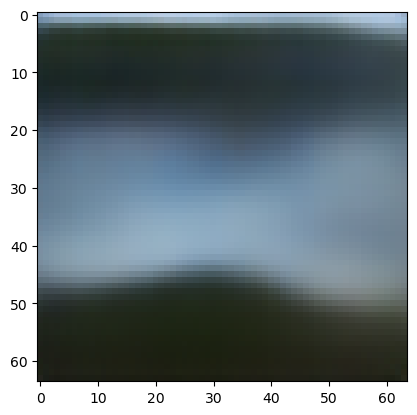

In [115]:
# real train
idx = random.randint(0, len(real_dataset)-1)
img = real_dataset[idx][0]
real_img = model(torch.from_numpy(img).unsqueeze(0).to(model.device)).squeeze().detach().cpu().numpy()
plt.imshow(np.transpose(real_img, [1, 2, 0])+0.5)

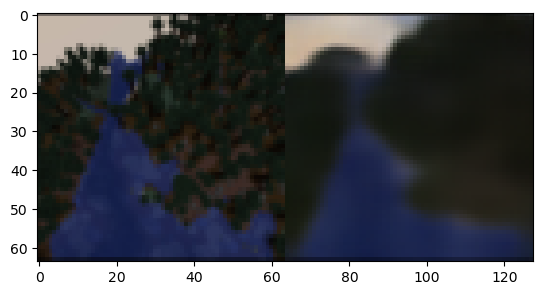

In [130]:
# minecraft train
idx = random.randint(0, len(minecraft_dataset)-1)
img = minecraft_dataset[idx][0]
real_img = model(torch.from_numpy(img).unsqueeze(0).to(model.device)).squeeze().detach().cpu().numpy()
real_img = np.transpose(real_img, [1, 2, 0])+0.5
img = np.transpose(img, [1, 2, 0])+0.5
joined = np.concatenate([img, real_img], axis=1)
plt.imshow(joined)

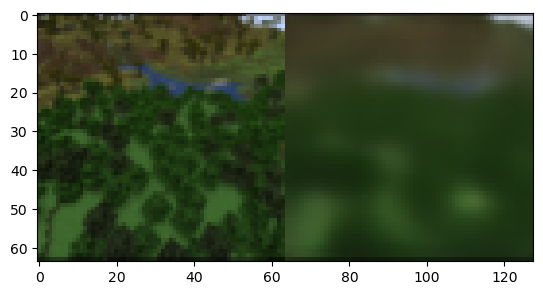

In [135]:
# minecraft test
idx = random.randint(0, len(test_dataset)-1)
img = test_dataset[idx][0]
real_img = model(torch.from_numpy(img).unsqueeze(0).to(model.device)).squeeze().detach().cpu().numpy()
real_img = np.transpose(real_img, [1, 2, 0])+0.5
img = np.transpose(img, [1, 2, 0])+0.5
joined = np.concatenate([img, real_img], axis=1)
plt.imshow(joined)

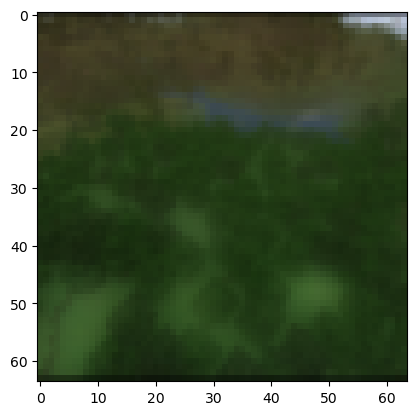

In [137]:
real_factor = 0.7
merged_img = img*(1-real_factor) + real_img*real_factor
plt.imshow(merged_img)

# Super resolution

In [44]:
import requests
from PIL import Image
from io import BytesIO
from diffusers import LDMSuperResolutionPipeline
import torch
import matplotlib.pyplot as plt

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/ldm-super-resolution-4x-openimages"

# load model and scheduler
pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/300 [00:00<?, ?it/s]

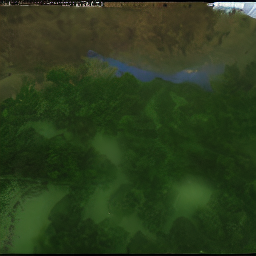

In [138]:
pil_img = Image.fromarray((merged_img*255).astype(np.uint8), 'RGB')
large = pipeline(pil_img, num_inference_steps=300, eta=1).images[0]
large

  0%|          | 0/300 [00:00<?, ?it/s]

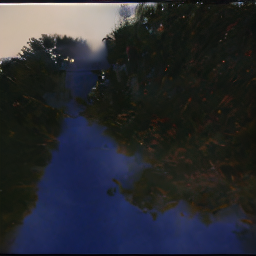

In [ ]:
pil_img = Image.fromarray((merged_img*255).astype(np.uint8), 'RGB')
large = pipeline(pil_img, num_inference_steps=300, eta=1).images[0]
large

  0%|          | 0/300 [00:00<?, ?it/s]

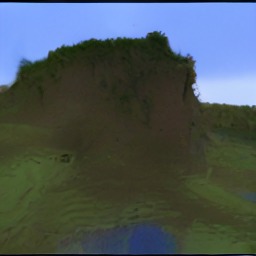

In [ ]:
pil_img = Image.fromarray((merged_img*255).astype(np.uint8), 'RGB')
large = pipeline(pil_img, num_inference_steps=300, eta=1).images[0]
large

  0%|          | 0/300 [00:00<?, ?it/s]

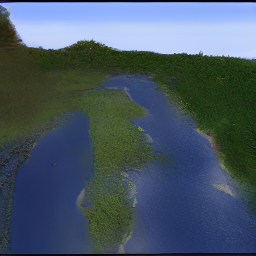

In [ ]:
pil_img = Image.fromarray((merged_img*255).astype(np.uint8), 'RGB')
large = pipeline(pil_img, num_inference_steps=300, eta=1).images[0]
large

  0%|          | 0/300 [00:00<?, ?it/s]

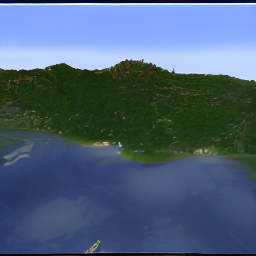

In [ ]:
pil_img = Image.fromarray((merged_img*255).astype(np.uint8), 'RGB')
large = pipeline(pil_img, num_inference_steps=300, eta=1).images[0]
large

  0%|          | 0/500 [00:00<?, ?it/s]

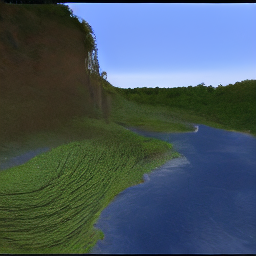

In [ ]:
pil_img = Image.fromarray((merged_img*255).astype(np.uint8), 'RGB')
large = pipeline(pil_img, num_inference_steps=500, eta=1).images[0]
large